In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sps

from phaseunwrapping import wrap_function

# Make toy data

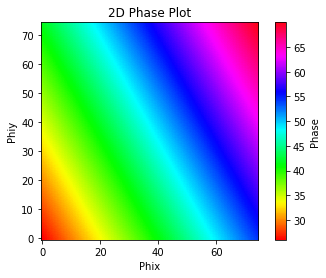

In [2]:
# create phase date for x and y direction
M = 75
N = 75
phix = np.linspace(0, 9*np.pi, M) + (3*np.pi) + 3
phiy = np.linspace(0, 5*np.pi, N) + (4*np.pi) + 1
X, Y = np.meshgrid(phix, phiy)
phi = X + Y

# Create the phase plot (source Chat GPT for the below code)
plt.imshow(phi, cmap='hsv', origin='lower')
plt.colorbar(label='Phase')
plt.xlabel('Phix')
plt.ylabel('Phiy')
plt.title('2D Phase Plot')
plt.show()

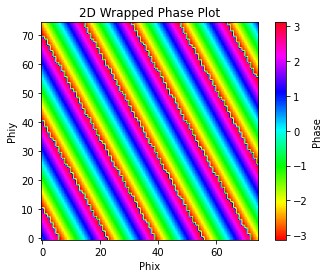

In [3]:
psi = wrap_function(phi)
plt.imshow(psi, cmap='hsv', origin='lower')
plt.colorbar(label='Phase')
plt.xlabel('Phix')
plt.ylabel('Phiy')
plt.title('2D Wrapped Phase Plot')
plt.show()


# MLE reconstruction

In [4]:
from phaseunwrapping import DiscreteGradientOperator2D, dct_diagonalized_operator_sqrt

In [36]:
# Build the relevant 2D discrete gradient operator
grid_shape = (M,N)
R = DiscreteGradientOperator2D(grid_shape)
RtR = R.T @ R

### With R^T R = E E^T for square E, compute the matrix E^{-1}. This can be used to solve the MLE problem.
### R^T R x = R^T y  => x = E^{-1} E^{-T} R^T y.
### Offset controls whether the zero-eigenvalue is modified. If it is, it is set equal to offset_val.
Einv = dct_diagonalized_operator_sqrt(RtR, grid_shape, offset=True, offset_val=1e0)
rhs = wrap_function(R @ psi.flatten()) # RHS vector in system
mle_phase = Einv.T @ Einv @ R.T @ rhs # Compute the MLE
mle_phase = mle_phase.reshape(grid_shape)   # Reshape it

### Note: the recovered phase will be correct up to a constant shift. You then need to add the constant
### shift you want. To get what we had before, the constant shifty you need to add is the difference between
### the observed phase psi and the first component of the recovered solution.

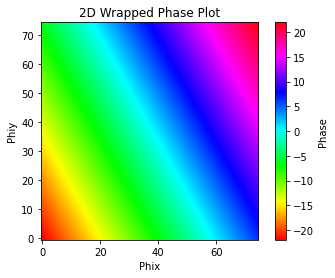

In [37]:
plt.imshow(mle_phase, cmap='hsv', origin='lower')
plt.colorbar(label='Phase')
plt.xlabel('Phix')
plt.ylabel('Phiy')
plt.title('2D Wrapped Phase Plot')
plt.show()


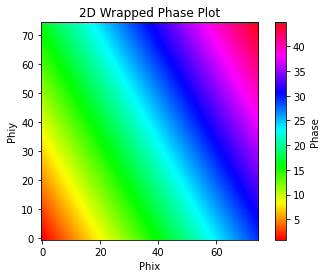

In [39]:
# Shifted so that it is comparable to the shift we were using before
shifted_mle_phase =  -mle_phase[0,0] + psi[0,0] + mle_phase
plt.imshow(shifted_mle_phase, cmap='hsv', origin='lower')
plt.colorbar(label='Phase')
plt.xlabel('Phix')
plt.ylabel('Phiy')
plt.title('2D Wrapped Phase Plot')
plt.show()


# Preconditioned CG MLE reconstruction

In [41]:
from scipy.sparse.linalg import aslinearoperator
from scipy.sparse import diags
import scipy.sparse as sps

from phaseunwrapping import relative_residual_cg, DiscreteGradientOperator2D, dct_diagonalized_operator_sqrt

In [49]:
# Build the relevant 2D discrete gradient operator
grid_shape = (M,N)
R = DiscreteGradientOperator2D(grid_shape)
RtR = R.T @ R

### With R^T R = E E^T for square E, compute the matrix E^{-1}. This can be used to solve the MLE problem.
### R^T R x = R^T y  => x = E^{-1} E^{-T} R^T y.
### Offset controls whether the zero-eigenvalue is modified. If it is, it is set equal to offset_val.
Einv = dct_diagonalized_operator_sqrt(RtR, grid_shape, offset=True, offset_val=1e0)
rhs = R.T @ wrap_function(R @ psi.flatten()) # RHS vector in system
mle_phase = Einv.T @ Einv @ rhs # Compute the MLE
mle_phase = mle_phase.reshape(grid_shape)   # Reshape it
#^ Still compute the MLE for comparison

### Setup for the weighted problem
np.random.seed(0)
weights = np.random.uniform(low=1.0, high=2.0, size=R.shape[0])
W = aslinearoperator(diags(weights))
RtWR = R.T @ (W @ R)

### Solve the preconditioned problem. Instead of solving R^T W R x = R^T b, it is equivalent to solve
###        E^{-1} R^T W R E^{-T} w = E^{-1} R^T b
### and recover x = E^{-T} w.
Qtilde = Einv @ RtWR @ Einv.T
rhs_tilde = Einv @ rhs

cg_sol_with_preconditioning = relative_residual_cg(Qtilde, rhs_tilde)
cg_sol_without_preconditioning = relative_residual_cg(RtWR, rhs)

print(f"n iterations with preconditioning: {cg_sol_with_preconditioning['iterations']}")
print(f"n iterations without preconditioning: {cg_sol_without_preconditioning['iterations']}")

n iterations with preconditioning: 10
n iterations without preconditioning: 353


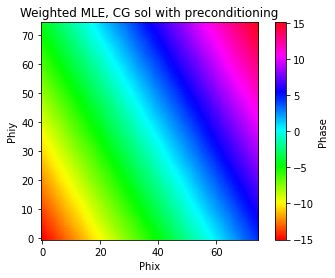

In [55]:
plt.imshow( (Einv.T @ cg_sol_with_preconditioning["x"]).reshape(grid_shape), cmap='hsv', origin='lower')
plt.colorbar(label='Phase')
plt.xlabel('Phix')
plt.ylabel('Phiy')
plt.title('Weighted MLE, CG sol with preconditioning')
plt.show()


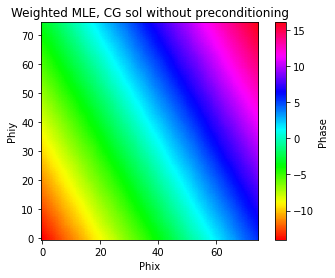

In [56]:
plt.imshow(cg_sol_without_preconditioning["x"].reshape(grid_shape), cmap='hsv', origin='lower')
plt.colorbar(label='Phase')
plt.xlabel('Phix')
plt.ylabel('Phiy')
plt.title('Weighted MLE, CG sol without preconditioning')
plt.show()

# Do it for a massive problem?

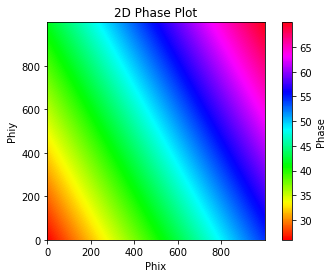

In [69]:
# create phase date for x and y direction
M = 1000
N = 1000
phix = np.linspace(0, 9*np.pi, M) + (3*np.pi) + 3
phiy = np.linspace(0, 5*np.pi, N) + (4*np.pi) + 1
X, Y = np.meshgrid(phix, phiy)
phi = X + Y

# Create the phase plot (source Chat GPT for the below code)
plt.imshow(phi, cmap='hsv', origin='lower')
plt.colorbar(label='Phase')
plt.xlabel('Phix')
plt.ylabel('Phiy')
plt.title('2D Phase Plot')
plt.show()

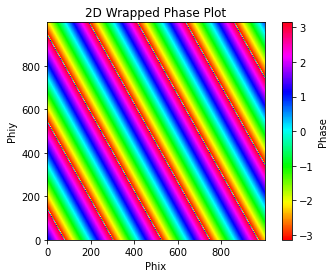

In [70]:
psi = wrap_function(phi)
plt.imshow(psi, cmap='hsv', origin='lower')
plt.colorbar(label='Phase')
plt.xlabel('Phix')
plt.ylabel('Phiy')
plt.title('2D Wrapped Phase Plot')
plt.show()


In [71]:
# Build the relevant 2D discrete gradient operator
grid_shape = (M,N)
R = DiscreteGradientOperator2D(grid_shape)
RtR = R.T @ R

### With R^T R = E E^T for square E, compute the matrix E^{-1}. This can be used to solve the MLE problem.
### R^T R x = R^T y  => x = E^{-1} E^{-T} R^T y.
### Offset controls whether the zero-eigenvalue is modified. If it is, it is set equal to offset_val.
Einv = dct_diagonalized_operator_sqrt(RtR, grid_shape, offset=True, offset_val=1e0)
rhs = wrap_function(R @ psi.flatten()) # RHS vector in system
mle_phase = Einv.T @ Einv @ R.T @ rhs # Compute the MLE
mle_phase = mle_phase.reshape(grid_shape)   # Reshape it

### Note: the recovered phase will be correct up to a constant shift. You then need to add the constant
### shift you want. To get what we had before, the constant shifty you need to add is the difference between
### the observed phase psi and the first component of the recovered solution.

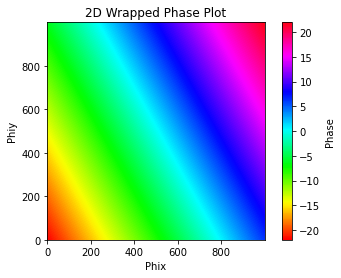

In [72]:
plt.imshow(mle_phase, cmap='hsv', origin='lower')
plt.colorbar(label='Phase')
plt.xlabel('Phix')
plt.ylabel('Phiy')
plt.title('2D Wrapped Phase Plot')
plt.show()


### Preconditioned problem?

In [73]:
# Build the relevant 2D discrete gradient operator
grid_shape = (M,N)
R = DiscreteGradientOperator2D(grid_shape)
RtR = R.T @ R

### With R^T R = E E^T for square E, compute the matrix E^{-1}. This can be used to solve the MLE problem.
### R^T R x = R^T y  => x = E^{-1} E^{-T} R^T y.
### Offset controls whether the zero-eigenvalue is modified. If it is, it is set equal to offset_val.
Einv = dct_diagonalized_operator_sqrt(RtR, grid_shape, offset=True, offset_val=1e0)
rhs = R.T @ wrap_function(R @ psi.flatten()) # RHS vector in system
mle_phase = Einv.T @ Einv @ rhs # Compute the MLE
mle_phase = mle_phase.reshape(grid_shape)   # Reshape it
#^ Still compute the MLE for comparison

### Setup for the weighted problem
np.random.seed(0)
weights = np.random.uniform(low=1.0, high=2.0, size=R.shape[0])
W = aslinearoperator(diags(weights))
RtWR = R.T @ (W @ R)

### Solve the preconditioned problem. Instead of solving R^T W R x = R^T b, it is equivalent to solve
###        E^{-1} R^T W R E^{-T} w = E^{-1} R^T b
### and recover x = E^{-T} w.
Qtilde = Einv @ RtWR @ Einv.T
rhs_tilde = Einv @ rhs

cg_sol_with_preconditioning = relative_residual_cg(Qtilde, rhs_tilde)

print(f"n iterations with preconditioning: {cg_sol_with_preconditioning['iterations']}")

n iterations with preconditioning: 12


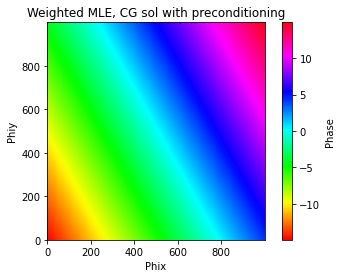

In [74]:
plt.imshow( (Einv.T @ cg_sol_with_preconditioning["x"]).reshape(grid_shape), cmap='hsv', origin='lower')
plt.colorbar(label='Phase')
plt.xlabel('Phix')
plt.ylabel('Phiy')
plt.title('Weighted MLE, CG sol with preconditioning')
plt.show()